In [1]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# Detect Trucks using Sentinel-2 data
## Parallax-based truck detection
--------------------
This notebook is a comprehensive script for detecting trucks with Sentinel-2 data. In order to run the detection in your area of interest you will have to modify two cells:
1. Area of Interest (specify the aoi as bounding box)
2. Date (specify an acquisition date)

Afterwards, you may simply run all cells and check the result at the end of the script where you can also write the detections as points.

Ensure that you have access to the Sentinel Hub resources for retrieving Sentinel-2 data through its API (via xcube_sh).

Author: Henrik Fisser, 2020\
Explanations on the truck detection on GitHub: https://github.com/hfisser/Truck_Detection_Sentinel2_COVID19

In [2]:
import os
import subprocess
import sys

# installations
def install_package(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
install_package("OSMPythonTools")
install_package("geocube")

# OSM API
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

import numpy as np
import xarray as xr
import geocube
import geopandas as gpd
import pandas as pd
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube.core.maskset import MaskSet
from rasterio import features
from affine import Affine
from shapely import geometry, coords
from shapely.geometry import Polygon, Point, box
from numba import jit

import IPython.display
%matplotlib inline

## Area of Interest
Specify an area of interest as bounding box in format:\
xmin, ymin, ymax, ymax

In [3]:
bbox = -3.85, 40.3, -3.55, 40.5 # Madrid
IPython.display.GeoJSON(box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

## Date
Select a cloud-free acquisition and provide the date as "YYYY-MM-DD".
You may select data e.g. here:\
**Copernicus Open Access Hub**
https://scihub.copernicus.eu/dhus/#/home \
**EO Browser**
https://apps.sentinel-hub.com/eo-browser/?zoom=10&lat=41.9&lng=12.5&themeId=DEFAULT-THEME

In [4]:
date_start = "2020-05-18"
date_end = "2020-05-19"

## Open Street Maps (OSM)
Trucks are only detected on roads obtained from OSM.
You may specify road types to include. Their descriptions can be found here:\
https://wiki.openstreetmap.org/wiki/Key:highway

In [5]:
osm_values = ["motorway", "trunk", "primary"] # all of key "highway"
roads_buffer = 0.00022 # degree, OSM road vectors are buffered, for motorway, the others lower

-----------------------------
## Processing methods
In the following cells all needed methods are defined. They will be invoked further below.

In [6]:
# re-order bbox from W,S,E,N to S,W,N,E
def convert_bbox_osm(bbox):
    offset = 0.05 # add a buffer to bbox in order to be sure cube is entirely covered
    bbox_osm = [bbox[1], bbox[0], bbox[3], bbox[2]]
    bbox_osm[0] -= offset # min lat
    bbox_osm[1] -= offset # min lon
    bbox_osm[2] += offset # max lat
    bbox_osm[3] += offset # max lon
    return bbox_osm

# bbox List of four coords
# osm_value String OSM value
# osm_key String OSM key
# element_type List of String
# returns GeoDataFrame
def get_osm(bbox, 
            osm_value,
            element_type = ["way", "relation"]):
    osm_key = "highway"
    bbox_osm = convert_bbox_osm(bbox)
    quot = '"'
    select = quot+osm_key+quot + '=' + quot+osm_value+quot
    select_link = select.replace(osm_value, osm_value + "_link") # also get road links
    select_junction = select.replace(osm_value, osm_value + "_junction")
    geoms = []
    for selector in [select, select_link, select_junction]:  
        try:
            query = overpassQueryBuilder(bbox=bbox_osm, 
                                         elementType=element_type, 
                                         selector=selector, 
                                         out='body',
                                         includeGeometry=True)
            elements = Overpass().query(query, timeout=60).elements()
            # create multiline of all elements
            if len(elements) > 0:
                for i in range(len(elements)):
                    elem = elements[i]
                    geoms.append(elem.geometry())
        except:
            Warning("Could not retrieve " + select)
    try:
        lines = gpd.GeoDataFrame(crs = "EPSG:4326", geometry = geoms)
        n = len(geoms)
        lines["osm_value"] = [osm_value]*n # add road type
        return lines
    except:
        Warning("Could not merge " + osm_value)
        
# buffer Float road buffer distance [m]
# bbox List of four coords
# bbox_id Integer processing id of bbox
# osm_values List of String OSM values
# osm_key String OSM key
# roads_buffer Float buffer width
# returns GeoDataFrame
def get_roads(bbox, osm_values, roads_buffer):
    osm_key = "highway"
    roads = []
    has_error = []
    offset = 0.00002
    buffer_dist = "buffer_distance"
    # buffer according to road type
    m,t,p,s,ter = "motorway", "trunk", "primary", "secondary", "tertiary"
    buffers = {m:roads_buffer, t:roads_buffer-offset, p:roads_buffer-(2*offset), s:roads_buffer-(3*offset), ter:roads_buffer-(4*offset)}
    osm_values_int = {m:1, t:2, p:3, s:4, ter:5}
    for osm_value in osm_values:
        roads_osm = get_osm(bbox, osm_value)
        try:
            roads_osm = get_osm(bbox, osm_value)
            roads_osm[buffer_dist] = [buffers[osm_value]] * len(roads_osm)
            roads_osm["osm_value_int"] = osm_values_int[osm_value]
            roads.append(roads_osm)
        except:
            has_error.append(1)
            print("'get_osm'" + "failed for bbox_id osm_value " + osm_value + "osm_key" + osm_key)
    if len(roads) > len(has_error):
        roads_merge = gpd.GeoDataFrame(pd.concat(roads, ignore_index=True), crs=roads[0].crs)
        buffered = roads_merge.buffer(distance=roads_merge[buffer_dist])
        roads_merge.geometry = buffered
        return roads_merge

# osm geodataframe of polygons
# reference_raster xarray with lat and lon
# returns numpy array
def rasterize_osm(osm, reference_raster):
    osm_values = list(set(osm["osm_value"]))
    nan_placeholder = 100
    road_rasters = []
    for osm_value in osm_values:
        osm_subset = osm[osm["osm_value"] == osm_value]
        raster = rasterize(osm_subset, reference_raster.lat, reference_raster.lon)
        cond = np.isfinite(raster)
        raster_osm = np.where(cond, list(osm_subset.osm_value_int)[0], nan_placeholder) # use placeholder instead of nan first
        raster_osm = raster_osm.astype(np.float)
        road_rasters.append(raster_osm)        
    # merge road types in one layer
    road_raster_np = np.array(road_rasters).min(axis=0) # now use the lowest value (highest road level) because some intersect
    road_raster_np[road_raster_np == nan_placeholder] = 0
    return road_raster_np # 0=no_road 1=motorway, 2=trunk, ...

def transform_lat_lon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(polygons, lat, lon, fill=np.nan):
    transform = transform_lat_lon(lat, lon)
    out_shape = (len(lat), len(lon))
    raster = features.rasterize(polygons.geometry, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float)
    return xr.DataArray(raster, coords={"lat":lat, "lon":lon}, dims=("lat", "lon"))

In [7]:
# TruckDetector detects trucks at acquisition-level
class TruckDetector():   
    def __init__(self, band_stack):
        is_none = band_stack is None
        self.band_stack = band_stack.chunk(band_stack.dims["lat"], band_stack.dims["lon"]) if not is_none else None
        self.no_truck_mask = None
        self.trucks = None
    
    def detect(self):
        B02 = self.band_stack.B02.persist().values
        B03 = self.band_stack.B03.persist().values
        B04 = self.band_stack.B04.persist().values
        B08 = self.band_stack.B08.persist().values
        B11 = self.band_stack.B11.persist().values
        no_truck_mask = calc_no_trucks(B02, B03, B04, B08, B11)
        trucks = detect_trucks(B02, B03, B04, no_truck_mask)
        lon_lat = {"lat":self.band_stack.lat, "lon":self.band_stack.lon}
        self.no_truck_mask = xr.DataArray(no_truck_mask, coords=lon_lat, dims=("lat", "lon"))
        self.trucks = xr.DataArray(trucks, coords=lon_lat, dims=("lat", "lon")).astype(np.int)
        self.filter_trucks()
                            
    def filter_trucks(self):
        self.trucks = filter_spatial_3x3_extended(self.trucks)
        
# take xarray and ensure each value with 1 in data has no neighbor with 1 in an extended 3x3 block. Extended means: horizontally and vertically
# it is also checked for the second-next pixel
# Method checks only surrounding of values equal 1
# arr xarray DataArray with values and lat lon
def filter_spatial_3x3_extended(arr):
    values = arr.values
    lon = arr.lon
    lat = arr.lat
    valid = np.where(arr == 1)
    for y,x in zip(valid[0], valid[1]):
        y_above = y - 1
        y_above_next = y - 2
        x_left = x - 1
        x_right = x + 1
        x_left_next = x - 2
        space_left = x_left >= 0
        space_right = x_right >= 0 and x_right < len(lon)
        space_above = y_above >= 0
        val_left_above = values[y_above, x_left] if space_left and space_above else 0
        val_right_above = values[y_above, x_right] if space_right and space_above else 0
        val_left = values[y, x_left] if space_left else 0
        val_above = values[y_above, x] if space_above else 0
        val_left_next = values[y, x_left_next] if x_left_next >= 0 else 0
        val_above_next = values[y_above_next, x] if y_above_next >= 0 else 0
        # if any of the values left, above and left above has 1 set current value 0
        if (val_left_above + val_right_above + val_left + val_above + val_left_next + val_above_next) >= 1:
            values[y,x] = 0
    arr.values = values
    return arr

# extracts coordinates at value in np array and returns points as GeoDataFrame
# data 2d np array
# match_value Float value in data where point coordinates are extracted
# lon_lat dict of:
### "lon": np array longitude values"
### "lat": np array latitude values"
# crs String EPSG:XXXX
def points_from_np(data, match_value, lon_lat, crs):
    indices = np.argwhere(data == match_value)
    if len(indices) > 0:
        lat_indices = indices[:,[0]]
        lon_indices = indices[:,[1]]
        lat_coords = lon_lat["lat"][lat_indices]
        lon_coords = lon_lat["lon"][lon_indices]
        points = gpd.GeoDataFrame(geometry = gpd.points_from_xy(lon_coords, lat_coords))
        points.crs = crs
        return points
    
def raster_to_points(raster, lon_lat, field_name, crs):
    points_list = []
    match_values = np.unique(raster[(raster != 0) * ~np.isnan(raster)]) # by pixel value
    for x in match_values:
        points = points_from_np(raster, x, lon_lat, crs=crs)
        points[field_name] = [x] * len(points)
        points_list.append(points)
    return gpd.GeoDataFrame(pd.concat(points_list, ignore_index=True))
        
# Calculate a binary mask where pixels that are definitely no trucks are represented as 0.
# thresholds Dict with at least:
### max_ndvi Float above this val: no trucks. For Vegetation
### max_ndwi Float above this val: no trucks. For Water
### max_ndsi Float above this val: no_trucks. For Snow
### min_rgb Float above this val: no_trucks. For dark surfaces, e.g. shadows
### max_blue Float above this val: no_trucks
### max_green Float above this val: no trucks
### max_red Float above this val: no trucks
### min_b11 Float below this val: no trucks. For dark surfaces, e.g. shadows
### max_b11 Float below this val: no trucks. For bright (sealed) surfaces, e.g. buildings
@jit(nopython=True, parallel=True)
def calc_no_trucks(B02, B03, B04, B08, B11):
    th = {"min_blue":0.06, 
          "min_green":0.04, 
          "min_red":0.04,
          "max_red":0.15,
          "max_green":0.15,
          "max_blue":0.2,
          "max_ndvi":0.5,
          "max_ndwi":0.0001,
          "max_ndsi":0.0001,
          "min_blue_green_ratio":0.03,
          "min_blue_red_ratio":0.05, 
          "max_blue_green_ratio":0.17, 
          "max_blue_red_ratio":0.2}
    ndvi_mask = ratio(B08, B04) < th["max_ndvi"]
    ndwi_mask = ratio(B02, B11) < th["max_ndwi"]
    ndsi_mask = ratio(B03, B11) < th["max_ndsi"]
    low_rgb_mask = (B02 > th["min_blue"]) * (B03 > th["min_green"]) * (B04 > th["min_red"])
    high_rgb_mask = (B02 < th["max_blue"]) * (B03 < th["max_green"]) * (B04 < th["max_red"])
    no_truck_mask = ndvi_mask * ndwi_mask * ndsi_mask * low_rgb_mask * high_rgb_mask
    return no_truck_mask

# Calculate a binary mask where trucks are represented as 1 and no trucks as 0.
# thresholds Dict with at least:
### min_green_ratio Float, minimum value of blue-green ratio
### min_red_ratio Float, minimum value of blue-red ratio
@jit(nopython=True, parallel=True)
def detect_trucks(B02, B03, B04, no_truck_mask):
    th = {"min_blue":0.06, 
          "min_green":0.04, 
          "min_red":0.04,
          "max_red":0.15,
          "max_green":0.15,
          "max_blue":0.2,
          "max_ndvi":0.5,
          "max_ndwi":0.0001,
          "max_ndsi":0.0001,
          "min_blue_green_ratio":0.03,
          "min_blue_red_ratio":0.05, 
          "max_blue_green_ratio":0.17, 
          "max_blue_red_ratio":0.2}
    bg_ratio = ratio(B02, B03)
    br_ratio = ratio(B02, B04)
    bg = bg_ratio > th["min_blue_green_ratio"]
    br = br_ratio > th["min_blue_red_ratio"]
    bg_max = bg_ratio < th["max_blue_green_ratio"]
    br_max = br_ratio < th["max_blue_red_ratio"]
    trucks = (bg * br * bg_max * br_max) * no_truck_mask
    return trucks

@jit(nopython=True, parallel=True)
def ratio(a, b):
    return (a-b)/(a+b)

In [8]:
# AcquisitionProcessor processes all valid pixels of a single acquisition in cube
class AcquisitionProcessor():
    def __init__(self, date_np64, cube):
        self.date_np64 = date_np64
        self.cube = cube
        self.band_stack = cube.sel(time = date_np64)
        self.detector = None
        self.no_clouds = None
        self.osm_mask = None
           
    def mask_clouds(self):
        cloud_masking_thresholds = {"rgb":0.25,"blue_green":0.2,"blue_red":0.2}
        scl = MaskSet(self.band_stack.SCL)
        high_prob = scl.clouds_high_probability
        med_prob = scl.clouds_medium_probability
        cirrus = scl.cirrus
        no_data = scl.no_data
        rgb_cloud_mask = calc_rgb_cloud_mask(self.band_stack, cloud_masking_thresholds)
        self.no_clouds = (high_prob + med_prob + cirrus + no_data + rgb_cloud_mask) == 0
        self.band_stack = self.band_stack.where(self.no_clouds)
    
    def mask_with_osm(self, osm_mask):
        self.osm_mask = osm_mask
        self.band_stack = self.band_stack.where(self.osm_mask != 0)
                
    def do_detection(self):
        self.detector = TruckDetector(self.band_stack)
        self.detector.detect()
        
def calc_rgb_cloud_mask(band_stack, cloud_masking_thresholds):
    B02, B03, B04 = band_stack.B02, band_stack.B03, band_stack.B04
    c = cloud_masking_thresholds["rgb"]
    clouds_rgb = ((B02 > c) + (B03 > c) + (B04 > c)) >= 1
    # attempt to mask haze without masking out truck pixels (similar! higher blue than red and green)
    blue_green_ratio = (B02-B03) / (B02+B03)
    blue_red_ratio = (B02-B04) / (B02+B04)
    clouds_blue_green = blue_green_ratio > cloud_masking_thresholds["blue_green"]
    clouds_blue_red = blue_red_ratio > cloud_masking_thresholds["blue_red"]
    clouds = (clouds_rgb + clouds_blue_green + clouds_blue_red) >= 1
    return clouds

-----------------
## Get Sentinel-2 L2A xcube

In [9]:
config = CubeConfig(dataset_name = "S2L2A",
                    band_names = ["B02", "B03", "B04", "B08", "B11", "SCL"],
                    tile_size = [512, 512],
                    geometry = bbox,
                    spatial_res = 0.00009,
                    time_range = [date_start, date_end])
cube = open_cube(config)

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube_sh/config.py:99: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')
/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Acquisition

In [10]:
acquisition = AcquisitionProcessor(cube.time.values[0], cube)

### Plot RGB

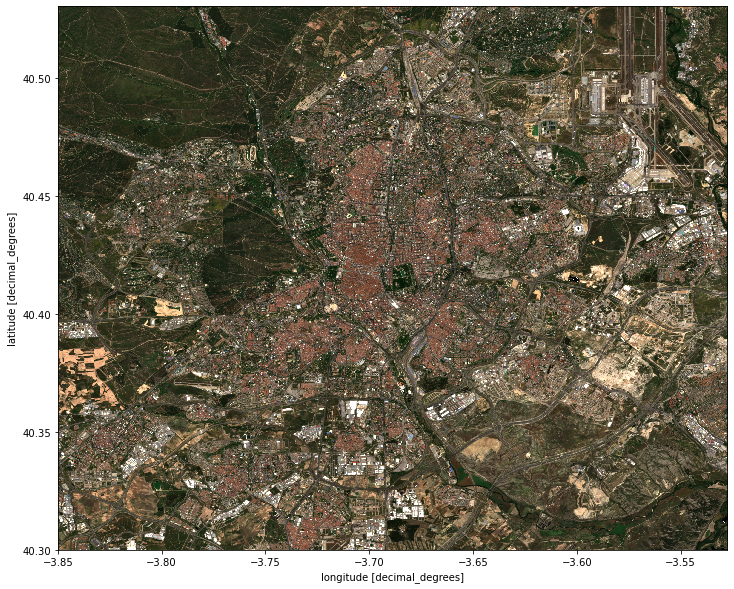

In [11]:
rgb_bands = ["B04", "B03", "B02"]
coords, dims = [rgb_bands, cube.lat, cube.lon], ["bands", "lat", "lon"]
rgb = np.vstack([cube.B04.persist().values, cube.B03.persist().values, cube.B02.persist().values])
rgb_xr = xr.DataArray(rgb, coords=coords, dims=dims)
rgb_xr.plot.imshow(figsize=[12,10], rgb="bands", vmin=0, vmax=0.4)
rgb, rgb_xr = None, None

RGB reflectance

## Get OSM roads

[overpass] downloading data: [timeout:60][out:json];(way["highway"="motorway"](40.25,-3.9,40.55,-3.5);relation["highway"="motorway"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="motorway_link"](40.25,-3.9,40.55,-3.5);relation["highway"="motorway_link"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="motorway_junction"](40.25,-3.9,40.55,-3.5);relation["highway"="motorway_junction"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="trunk"](40.25,-3.9,40.55,-3.5);relation["highway"="trunk"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="trunk_link"](40.25,-3.9,40.55,-3.5);relation["highway"="trunk_link"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="trunk_junction"](40.25,-3.9,40.55,-3.5);relation["highway"="trunk_junction"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="primary"](40.25,-3.9,40.55,-3.5);relation["highway"="primary"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="primary_link"](40.25,-3.9,40.55,-3.5);relation["highway"="primary_link"](40.25,-3.9,40.55,-3.5);); out body geom;


[overpass] downloading data: [timeout:60][out:json];(way["highway"="primary_junction"](40.25,-3.9,40.55,-3.5);relation["highway"="primary_junction"](40.25,-3.9,40.55,-3.5);); out body geom;


<ipython-input-6-00aa5324d1df>:78: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered = roads_merge.buffer(distance=roads_merge[buffer_dist])


<AxesSubplot:>

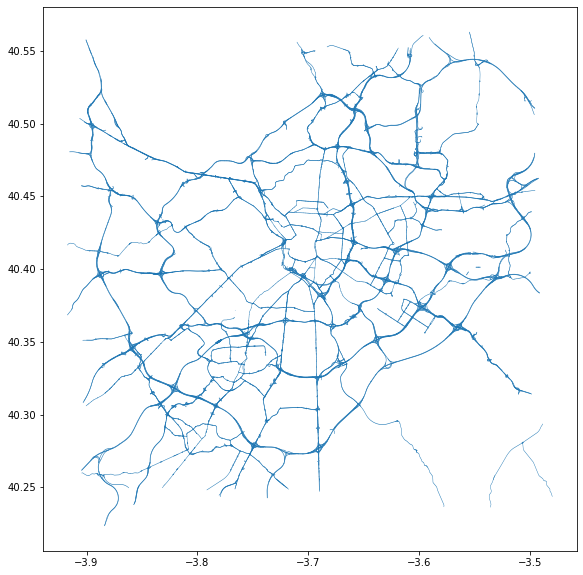

In [12]:
osm_roads = get_roads(bbox, osm_values, roads_buffer)
osm_roads.plot(figsize=[12,10])

The OSM road vectors are buffered, hence we see polygons here.

### Rasterize OSM roads to S2 cube

In [13]:
osm_roads_np = rasterize_osm(osm_roads, cube.B02)

<ipython-input-6-00aa5324d1df>:94: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raster_osm = raster_osm.astype(np.float)


## Mask
In case there are clouds in the imagery, they are masked out here. Furthermore, the data is constrained to the OSM roads.

### Clouds

In [14]:
acquisition.mask_clouds()

### To OSM roads
Only pixels within the buffered OSM roads are considered.

In [15]:
acquisition.mask_with_osm(osm_roads_np)

## Detect trucks
This is the actual detection being invoked in the "do_detection" wrapper. The output is an xarray DataArray, which is afterwards converted to a GeoDataFrame of points.

<ipython-input-7-916cb7c1a86e>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.trucks = xr.DataArray(trucks, coords=lon_lat, dims=("lat", "lon")).astype(np.int)


<AxesSubplot:>

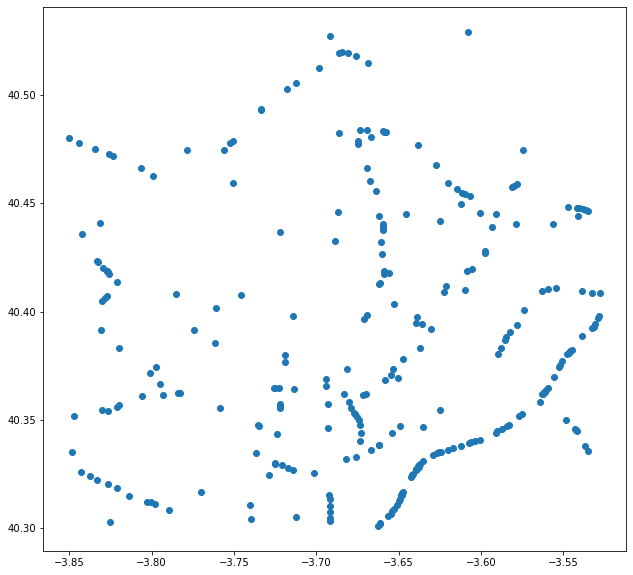

In [16]:
acquisition.do_detection()
# raster detections to points
truck_points = raster_to_points(acquisition.detector.trucks.values, {"lon":cube.lon.values, "lat":cube.lat.values}, "trucks", "EPSG:4326")
truck_points.plot(figsize=[12,10])

## Write detections
If you would like to write the truck points, simply modify the file path here

In [17]:
truck_points.to_file("trucks.gpkg", driver="GPKG")